# Spotify Music Recommendation System

## 1. Data Preparation and Exploration

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv("spotify_dataset.csv")

# Display basic information about the dataset
print(df.info())
print("\nDataset Shape:", df.shape)
print("\nFirst few rows:\n", df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50937 entries, 0 to 50936
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     50937 non-null  object 
 1   artist                   50934 non-null  object 
 2   spotify_id               50935 non-null  object 
 3   preview                  32539 non-null  object 
 4   img                      50932 non-null  object 
 5   danceability             50936 non-null  float64
 6   energy                   50936 non-null  float64
 7   loudness                 50936 non-null  float64
 8   speechiness              50936 non-null  float64
 9   acousticness             50936 non-null  float64
 10  instrumentalness         50936 non-null  float64
 11  liveness                 50936 non-null  float64
 12  valence                  50936 non-null  float64
 13  acousticness_artist      50936 non-null  float64
 14  danceability_artist   

In [3]:
# Select features for recommendation
recommendation_features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence'
]

# Prepare the feature matrix
X = df[recommendation_features].dropna()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2. Recommendation Models Evaluation

In [4]:
# Model 1: Cosine Similarity
def cosine_similarity_recommender(input_song_index, X_scaled, df, top_n=5):
    # Compute cosine similarity matrix
    cos_sim = cosine_similarity(X_scaled)

    # Get similarity scores for the input song
    sim_scores = list(enumerate(cos_sim[input_song_index]))

    # Sort the songs based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top N similar song indices (excluding the input song)
    top_indices = [i[0] for i in sim_scores[1:top_n+1]]

    # Return top N recommended songs
    return df.iloc[top_indices][['name', 'artist'] + recommendation_features]

In [5]:
# Model 2: K-Nearest Neighbors
def knn_recommender(input_song_index, X_scaled, df, top_n=5, n_neighbors=10):
    # Fit KNN model
    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='cosine')
    knn.fit(X_scaled)

    # Find nearest neighbors
    distances, indices = knn.kneighbors(X_scaled[input_song_index].reshape(1, -1))

    # Get top N similar song indices (excluding the input song)
    similar_indices = [idx for idx in indices[0] if idx != input_song_index][:top_n]

    # Return top N recommended songs
    return df.iloc[similar_indices][['name', 'artist'] + recommendation_features]

In [6]:
# Model 3: K-Means Clustering
def kmeans_recommender(input_song_index, X_scaled, df, top_n=5, n_clusters=10):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # Find the cluster of the input song
    input_cluster = clusters[input_song_index]

    # Find songs in the same cluster
    cluster_indices = np.where(clusters == input_cluster)[0]

    # Remove the input song from cluster indices
    cluster_indices = [idx for idx in cluster_indices if idx != input_song_index]

    # If not enough songs in the cluster, get similar songs
    if len(cluster_indices) < top_n:
        # Use cosine similarity to fill the recommendations
        cos_sim = cosine_similarity(X_scaled)
        sim_scores = list(enumerate(cos_sim[input_song_index]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        additional_indices = [i[0] for i in sim_scores if i[0] not in cluster_indices + [input_song_index]][:top_n]
        cluster_indices.extend(additional_indices)

    # Return top N recommended songs
    return df.iloc[cluster_indices[:top_n]][['name', 'artist'] + recommendation_features]

## 3. Model Evaluation and Comparison

In [7]:
# Function to visualize model recommendations
def visualize_recommendations(input_song, recommendations, model_name):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    # Plot input song features
    plt.bar(recommendation_features, input_song[recommendation_features].values)
    plt.title(f"Input Song: {input_song['name']} by {input_song['artist']}")
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 2, 2)
    # Plot recommended songs features
    recommendations_features = recommendations[recommendation_features]
    plt.bar(recommendation_features, recommendations_features.mean())
    plt.title(f"{model_name} Recommendations")
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [8]:
# Demonstrate recommendations for a sample song
# Choose a random song index
sample_song_index = 0  # You can change this to any index
input_song = df.iloc[sample_song_index]


K-Nearest Neighbors Recommendations:
                  name                 artist  danceability  energy  loudness  \
37622          Shotgun            George Ezra         0.672   0.735    -4.733   
43746        Indeleble  Banda Los Sebastianes         0.745   0.684    -3.700   
1335   La Boca - Remix            Mau y Ricky         0.691   0.773    -3.812   
33064         Fairlane     The Dirty Guv'nahs         0.684   0.772    -4.270   
37860          La Zona              Bad Bunny         0.762   0.801    -3.661   

       speechiness  acousticness  instrumentalness  liveness  valence  
37622       0.0457         0.286          0.000000     0.242    0.754  
43746       0.0274         0.283          0.000003     0.248    0.781  
1335        0.0355         0.236          0.000000     0.329    0.850  
33064       0.0292         0.279          0.000000     0.301    0.731  
37860       0.0409         0.200          0.000070     0.254    0.810  


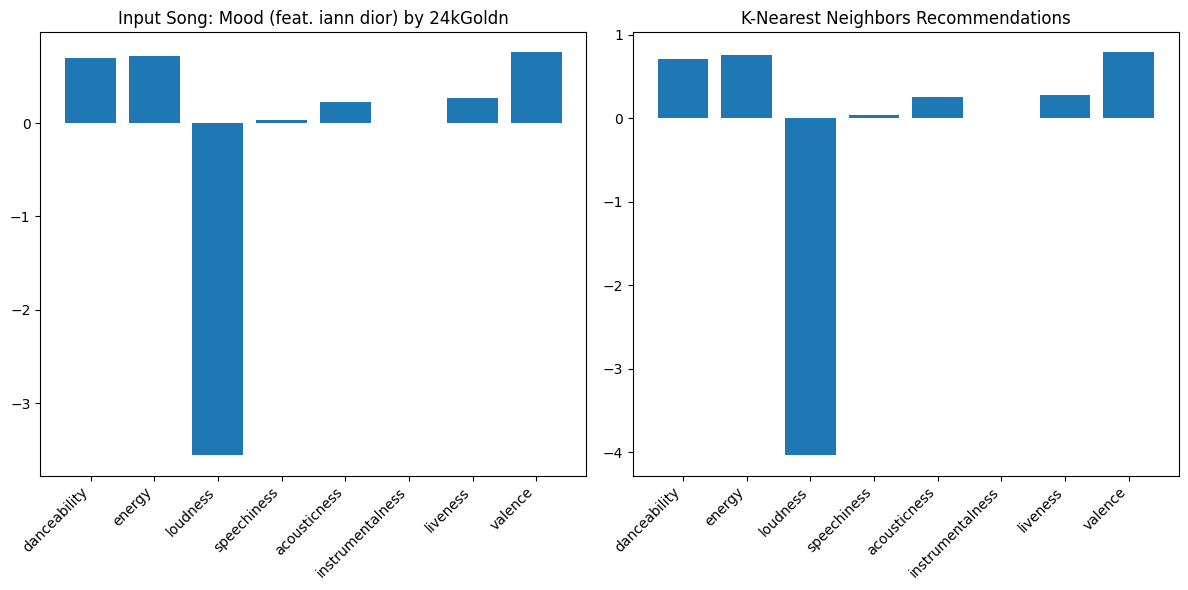

In [9]:
knn_recommendations = knn_recommender(sample_song_index, X_scaled, df)

print("\nK-Nearest Neighbors Recommendations:")
print(knn_recommendations)
visualize_recommendations(input_song, knn_recommendations, "K-Nearest Neighbors")



K-Means Clustering Recommendations:
                                    name          artist  danceability  \
26  ily (i love you baby) (feat. Emilee)       Surf Mesa         0.674   
29     Stuck with U (with Justin Bieber)   Ariana Grande         0.597   
40       Rain On Me (with Ariana Grande)       Lady Gaga         0.672   
53                               ROXANNE  Arizona Zervas         0.621   
63                                 Daisy        Ashnikko         0.834   

    energy  loudness  speechiness  acousticness  instrumentalness  liveness  \
26   0.774    -7.567       0.0892        0.0686           0.00188     0.393   
29   0.450    -6.658       0.0418        0.2230           0.00000     0.382   
40   0.855    -3.764       0.0397        0.0210           0.00000     0.323   
53   0.601    -5.616       0.1480        0.0522           0.00000     0.460   
63   0.663    -6.143       0.1330        0.2350           0.00000     0.372   

    valence  
26    0.330  
29    0.537  
4

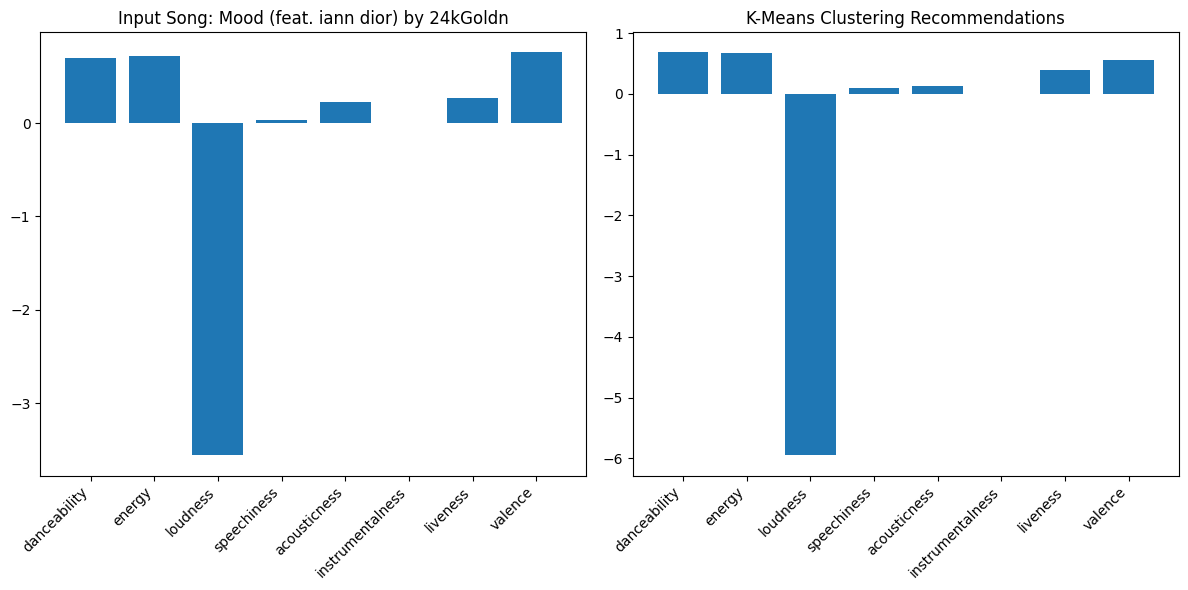

In [10]:

kmeans_recommendations = kmeans_recommender(sample_song_index, X_scaled, df)

print("\nK-Means Clustering Recommendations:")
print(kmeans_recommendations)
visualize_recommendations(input_song, kmeans_recommendations, "K-Means Clustering")

In [ ]:
# Get recommendations from different models
cosine_recommendations = cosine_similarity_recommender(sample_song_index, X_scaled, df)

# Visualize recommendations
print("Cosine Similarity Recommendations:")
print(cosine_recommendations)
visualize_recommendations(input_song, cosine_recommendations, "Cosine Similarity")


## 4. Playlist Recommendation Function

In [ ]:
def playlist_recommender(playlist_songs, df, X_scaled, top_n=10, method='knn'):
    # Find indices of playlist songs in the dataset
    playlist_indices = []
    for song in playlist_songs:
        # Find song by name and artist
        match = df[(df['name'] == song['name']) & (df['artist'] == song['artist'])]
        if not match.empty:
            playlist_indices.append(match.index[0])

    if not playlist_indices:
        raise ValueError("No matching songs found in the dataset")

    # Aggregate recommendations
    all_recommendations = []
    for index in playlist_indices:
        if method == 'cosine':
            recs = cosine_similarity_recommender(index, X_scaled, df, top_n=5)
        elif method == 'knn':
            recs = knn_recommender(index, X_scaled, df, top_n=5)
        else:
            recs = kmeans_recommender(index, X_scaled, df, top_n=5)
        all_recommendations.extend(recs.to_dict('records'))

    # Remove duplicates and limit to top N
    unique_recommendations = []
    seen = set()
    for rec in all_recommendations:
        key = (rec['name'], rec['artist'])
        if key not in seen:
            seen.add(key)
            unique_recommendations.append(rec)

    return pd.DataFrame(unique_recommendations[:top_n])

In [ ]:
# Example playlist recommendation
example_playlist = [
    {'name': 'Mood (feat. iann dior)', 'artist': '24kGoldn'}
    # Add more songs from your dataset
]

# Generate recommendations
cosine_playlist_recs = playlist_recommender(example_playlist, df, X_scaled, method='cosine')
print("Playlist Recommendations (Cosine Similarity):")
print(cosine_playlist_recs)

## 5. Model Performance Evaluation

Note: Proper recommendation system evaluation requires ground truth data or user feedback, which is not available in this dataset.

In [ ]:
# Optional: Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.title('PCA Visualization of Songs')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()